# NFL Combine Draft Classification  
## A Logistic Regression Analysis

### Eric Au

<img src="https://library.sportingnews.com/styles/twitter_card_120x120/s3/2022-03/Antoine-Winfield-030222-GETTY-FTR.jpg?itok=nG3hUgf_" width="500" length = "200"/>

Source: <a href="https://www.sportingnews.com/us/nfl/news/nfl-combine-drills-explained-40-yard-dash/lds11epxn7znufqyjkaphguq">Getty Images</a>

### Business and Data Understanding

Every year, the National Football League (NFL) holds a week long showcase where college football players, otherwise known as prospects, perform physical drills and tests in front of team coaches, scouts, and general managers. These drills are intended to measure a player's physical ability such as speed, quickness, strength, and overall athleticism. 

But what can NFL teams learn from these workouts? What exactly do the non-football athletic testing measurements contribute to prospect evaluation? These are a questions that many fans ask to this day and NFL teams try to interpret to make the best decision possible when drafting their players. 

For this analysis, we will be using player combine data scraped from <a href = "https://www.pro-football-reference.com/">Pro-Football Reference</a> over the last 22 years (2000-2022). 

Each record represents an individual player who was eligible to be drafted with information related to their combine measurements. Additionally, each record indicates whether that player was `Drafted` with 1 for "Yes" and 0 for "No". This will be further clarified in the preliminary cleaning of the data set. 

**The task is to predict whether a player was `Drafted` based on the available data and information provided in the NFL Combine.** 

**Stakeholders:** The New York Giants front office (General Manager, President, Scouting Department). 


In [1]:
# import libraries 
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer

from sklearn.base import clone

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [2]:
# load in data
df = pd.read_csv('Data/combine_2000_2022.csv', index_col = 0)
df.head()

,Player,Pos,School,College,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr),Year
0,John Abraham,OLB,South Carolina,NaN,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN,New York Jets / 1st / 13th pick / 2000,2000
1,Shaun Alexander,RB,Alabama,College Stats,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,Seattle Seahawks / 1st / 19th pick / 2000,2000
2,Darnell Alford,OT,Boston Col.,NaN,6-4,334.0,5.56,25.0,23.0,94.0,8.48,4.98,Kansas City Chiefs / 6th / 188th pick / 2000,2000
3,Kyle Allamon,TE,Texas Tech,NaN,6-2,253.0,4.97,29.0,NaN,104.0,7.29,4.49,NaN,2000
4,Rashard Anderson,CB,Jackson State,NaN,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15,Carolina Panthers / 1st / 23rd pick / 2000,2000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7680 entries, 0 to 7820
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               7680 non-null   object 
 1   Pos                  7680 non-null   object 
 2   School               7680 non-null   object 
 3   College              6240 non-null   object 
 4   Ht                   7651 non-null   object 
 5   Wt                   7656 non-null   float64
 6   40yd                 7206 non-null   float64
 7   Vertical             5932 non-null   float64
 8   Bench                5096 non-null   float64
 9   Broad Jump           5859 non-null   float64
 10  3Cone                4792 non-null   float64
 11  Shuttle              4895 non-null   float64
 12  Drafted (tm/rnd/yr)  4937 non-null   object 
 13  Year                 7680 non-null   int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 900.0+ KB


## Initial Data Preparation
### Convert to float types in appropriate columns; 

In [4]:
# create a list of columns that need to be floats
col_floats = ['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

In [5]:
# convert to type float for col_floats columns
df[col_floats].astype(float)

,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,252.0,4.55,NaN,NaN,NaN,NaN,NaN
1,218.0,4.58,NaN,NaN,NaN,NaN,NaN
2,334.0,5.56,25.0,23.0,94.0,8.48,4.98
3,253.0,4.97,29.0,NaN,104.0,7.29,4.49
4,206.0,4.55,34.0,NaN,123.0,7.18,4.15
...,...,...,...,...,...,...,...
7816,304.0,4.77,29.0,NaN,111.0,NaN,NaN
7817,255.0,NaN,NaN,NaN,NaN,NaN,NaN
7818,206.0,NaN,NaN,12.0,NaN,NaN,NaN
7819,316.0,5.13,28.5,27.0,110.0,7.75,4.71


### Remove missing data

In [6]:
# there are 29 missing heights in the dataframe
missing_heights = df[df['Ht'].isna()].index
len(missing_heights)

29

In [7]:
# remove these rows from the df
df = df.drop(missing_heights)

In [8]:
# check shape (7680 - 29) = 7651
df.shape

(7651, 14)

### Convert `Height` to appropriate float value

In [9]:
# create feet and inches columns to seperate the 'Ht'
df['feet'] = df['Ht'].str.split("-").str[0].astype(int)
df['inches'] = df['Ht'].str.split("-").str[1].astype(int)

# add new Height column that calculates height as a float
df['Height'] = df['feet'] + round((df['inches']/12),2)

In [10]:
# remove unneeded columns and extra columns created
df = df.drop(columns = ['Player', 'Ht', 'College','feet', 'inches'])

In [11]:
# rename the columns
df = df[['Pos', 'School', 'Height', 'Wt', '40yd', 'Vertical', 'Bench',
       'Broad Jump', '3Cone', 'Shuttle', 'Drafted (tm/rnd/yr)', 'Year']]

### Create binary `Drafted ` Column of 1 - Yes, 0 - No if player was drafted

In [12]:
# fill missing in drafted column with 0
df['Drafted (tm/rnd/yr)'] = df['Drafted (tm/rnd/yr)'].fillna(0)

In [13]:
# create new column Drafted that designates whether drafted (1) or not (0)
df['Drafted'] = np.where(df['Drafted (tm/rnd/yr)'] == 0, 0, 1)

# drop extra drafted column now
df.drop(columns = 'Drafted (tm/rnd/yr)', inplace = True)

In [14]:
df.head(5)

,Pos,School,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,Drafted
0,OLB,South Carolina,6.33,252.0,4.55,NaN,NaN,NaN,NaN,NaN,2000,1
1,RB,Alabama,6.00,218.0,4.58,NaN,NaN,NaN,NaN,NaN,2000,1
2,OT,Boston Col.,6.33,334.0,5.56,25.0,23.0,94.0,8.48,4.98,2000,1
3,TE,Texas Tech,6.17,253.0,4.97,29.0,NaN,104.0,7.29,4.49,2000,0
4,CB,Jackson State,6.17,206.0,4.55,34.0,NaN,123.0,7.18,4.15,2000,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7651 entries, 0 to 7820
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pos         7651 non-null   object 
 1   School      7651 non-null   object 
 2   Height      7651 non-null   float64
 3   Wt          7651 non-null   float64
 4   40yd        7191 non-null   float64
 5   Vertical    5919 non-null   float64
 6   Bench       5082 non-null   float64
 7   Broad Jump  5850 non-null   float64
 8   3Cone       4784 non-null   float64
 9   Shuttle     4888 non-null   float64
 10  Year        7651 non-null   int64  
 11  Drafted     7651 non-null   int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 777.1+ KB


In [16]:
df.head()

,Pos,School,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,Drafted
0,OLB,South Carolina,6.33,252.0,4.55,NaN,NaN,NaN,NaN,NaN,2000,1
1,RB,Alabama,6.00,218.0,4.58,NaN,NaN,NaN,NaN,NaN,2000,1
2,OT,Boston Col.,6.33,334.0,5.56,25.0,23.0,94.0,8.48,4.98,2000,1
3,TE,Texas Tech,6.17,253.0,4.97,29.0,NaN,104.0,7.29,4.49,2000,0
4,CB,Jackson State,6.17,206.0,4.55,34.0,NaN,123.0,7.18,4.15,2000,1


In [17]:
df.describe()

,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year,Drafted
count,7651.000000,7651.000000,7191.000000,5919.000000,5082.000000,5850.000000,4784.000000,4888.000000,7651.000000,7651.000000
mean,6.149007,242.735852,4.776540,32.892854,20.744392,114.590769,7.284933,4.399677,2011.191609,0.643315
std,0.220414,45.236972,0.304748,4.217085,6.378024,9.351811,0.417687,0.267133,6.678314,0.479052
min,5.330000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,2000.000000,0.000000
25%,6.000000,205.000000,4.540000,30.000000,16.000000,109.000000,6.980000,4.200000,2005.000000,0.000000
50%,6.170000,232.000000,4.690000,33.000000,21.000000,116.000000,7.190000,4.360000,2011.000000,1.000000
75%,6.330000,280.000000,4.980000,36.000000,25.000000,121.000000,7.530000,4.560000,2017.000000,1.000000
max,6.830000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000,2022.000000,1.000000


### Position Breakdown

- possibly come back here to see how final model performs based on splitting up by offensive and defensive positions

In [18]:
# check positions available
df['Pos'].value_counts()

WR      1058
CB       761
RB       671
S        559
OT       524
DE       519
DT       497
OLB      430
TE       425
QB       416
OG       403
ILB      276
C        184
LB       154
P        142
OL       139
FB       120
DL       116
K        103
EDGE      65
DB        59
LS        30
Name: Pos, dtype: int64

In [19]:
# list of offensive positions
offense_list = ['WR', 'RB', 'OT', 'TE', 'QB', 'OG', 'C', 'OL', 'FB']

# list of defensive positions
defense_list = ['CB', 'S', 'DE', 'DT', 'OLB', 'ILB', 'LB', 'DL', 'EDGE', 'DB']

# list of special team positions
special_teams_list = ['LS', 'K', 'P']

In [20]:
# split into offensive positions
offense = df.loc[df['Pos'].isin(offense_list)]

# split into defensive positions
defense = df.loc[df['Pos'].isin(defense_list)]

# split into special teams positions
special_teams = df.loc[df['Pos'].isin(special_teams_list)]

In [21]:
# percent and count breakdowns
# Offense
total_offense = len(offense)
total_offense_drafted = offense['Drafted'].value_counts()[1]
total_offense_undrafted = offense['Drafted'].value_counts()[0]
percent_off_drafted = round(offense['Drafted'].value_counts(normalize = True)[1], 2)
percent_off_undrafted = round(offense['Drafted'].value_counts(normalize = True)[0], 2)

print("Offense")
print(f"Total Players:      {total_offense}")
print(f"Total Drafted:      {total_offense_drafted}")
print(f"Total Undrafted:    {total_offense_undrafted}")
print(f"Percent Drafted:    {percent_off_drafted}")
print(f"Percent Undrafted:  {percent_off_undrafted}")
print("-"*25)

# Defense
total_defense = len(defense)
total_defense_drafted = defense['Drafted'].value_counts()[1]
total_defense_undrafted = defense['Drafted'].value_counts()[0]
percent_def_drafted = round(defense['Drafted'].value_counts(normalize = True)[1], 2)
percent_def_undrafted = round(defense['Drafted'].value_counts(normalize = True)[0], 2)

print("Defense")
print(f"Total Players:      {total_defense}")
print(f"Total Drafted:      {total_defense_drafted}")
print(f"Total Undrafted:    {total_defense_undrafted}")
print(f"Percent Drafted:    {percent_def_drafted}")
print(f"Percent Undrafted:  {percent_def_undrafted}")
print("-"*25)

# Special teams
total_st = len(special_teams)
total_st_drafted = special_teams['Drafted'].value_counts()[1]
total_st_undrafted = special_teams['Drafted'].value_counts()[0]
percent_st_drafted = round(special_teams['Drafted'].value_counts(normalize = True)[1], 2)
percent_st_undrafted = round(special_teams['Drafted'].value_counts(normalize = True)[0], 2)

print("Special Teams")
print(f"Total Players:      {total_st}")
print(f"Total Drafted:      {total_st_drafted}")
print(f"Total Undrafted:    {total_st_undrafted}")
print(f"Percent Drafted:    {percent_st_drafted}")
print(f"Percent Undrafted:  {percent_st_undrafted}")

Offense
Total Players:      3940
Total Drafted:      2447
Total Undrafted:    1493
Percent Drafted:    0.62
Percent Undrafted:  0.38
-------------------------
Defense
Total Players:      3436
Total Drafted:      2397
Total Undrafted:    1039
Percent Drafted:    0.7
Percent Undrafted:  0.3
-------------------------
Special Teams
Total Players:      275
Total Drafted:      78
Total Undrafted:    197
Percent Drafted:    0.28
Percent Undrafted:  0.72


## Exploratory Data Analysis

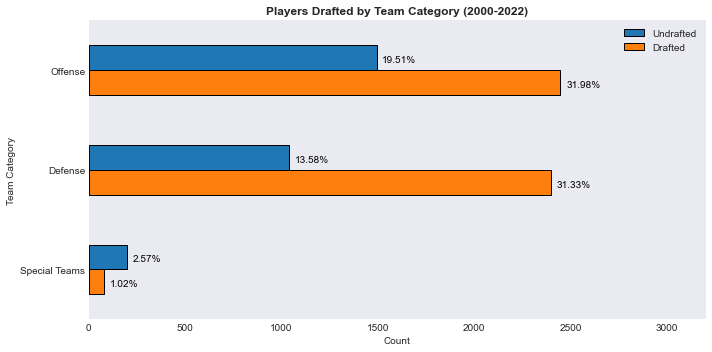

In [22]:
# plot visual breakdown of drafted by team category 
position_category = ['Offense', 'Defense', 'Special Teams']

data = {'Drafted': [total_offense_drafted, total_defense_drafted, total_st_drafted],
        'Undrafted': [total_offense_undrafted, total_defense_undrafted, total_st_undrafted]
       }

# create dataframe of positions & number of drafted
drafted = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'], 
                       index = position_category)

plt.style.use('seaborn-dark')


fig, ax = plt.subplots(figsize=(10, 5))

drafted.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = False,
             xlim = (0, 3200))

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+ 30, i.get_y() + 0.17, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,
color='black')

# invert for largest on top 
ax.invert_yaxis()

plt.title('Players Drafted by Team Category (2000-2022)', weight = "bold")
plt.ylabel('Team Category')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

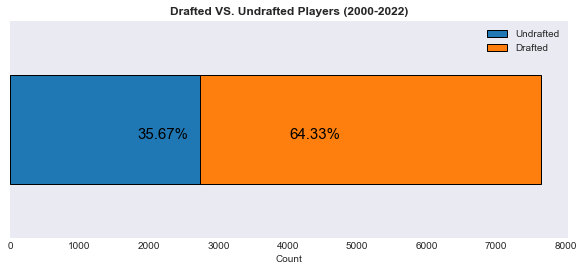

In [23]:
# create dict of drafted/undrafted with sums of each category
total = ['']

data = {'Undrafted': [drafted['Undrafted'].sum()],
        'Drafted': [drafted['Drafted'].sum()]
        }

# new drafted_total df
drafted_total = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'],
                       index = total)

plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(10, 4))

drafted_total.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = True)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-900, i.get_y()+.21, \
            str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=15,
            color='black')

ax.set_xlabel('Count')

ax.set(ylabel=None)
ax.set_title('Drafted VS. Undrafted Players (2000-2022)', weight = "bold")
ax.legend()

plt.show()

## Train-Test Split

Based on the early exploratory data analysis on the drafted vs. undrafted players, this dataset is relatively imbalanced at a 2:1 ratio. Below we will perform a Train-Test Split and specify a `stratify=y` to ensure an even balance of drafted and undrafted player in the split. 

In [24]:
# feature selection, target variable = 'Drafted'
X = df.drop(['Drafted'], axis = 1)
y = df['Drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

In [25]:
# check that percent in y_train and y_test for drafted is balanced
print("Train percent Drafted:", y_train.value_counts(normalize=True)[1])
print("Test percent Drafted: ", y_test.value_counts(normalize=True)[1])

Train percent Drafted: 0.6432554897176717
Test percent Drafted:  0.643491897543126


### Handling Missing Values

In [26]:
X_train.isna().sum()

Pos              0
School           0
Height           0
Wt               0
40yd           344
Vertical      1330
Bench         1943
Broad Jump    1378
3Cone         2173
Shuttle       2097
Year             0
dtype: int64

In [27]:
f = (X_train['40yd'].isna().sum()/X_train.shape[0]).round(2) * 100
v = (X_train['Vertical'].isna().sum()/X_train.shape[0]).round(2) * 100
b = (X_train['Bench'].isna().sum()/X_train.shape[0]).round(2) * 100
bj = (X_train['Broad Jump'].isna().sum()/X_train.shape[0]).round(2) * 100
c = (X_train['3Cone'].isna().sum()/X_train.shape[0]).round(2) * 100
s = (X_train['Shuttle'].isna().sum()/X_train.shape[0]).round(2) * 100

print(f'{f}% of 40yd is missing.')
print(f'{v}% of Vertical is missing.')
print(f'{b}% of Bench is missing.')
print(f'{bj}% of Broad Jump is missing.')
print(f'{c}% of 3Cone is missing.')
print(f'{s}% of Shuttle is missing.')

6.0% of 40yd is missing.
23.0% of Vertical is missing.
34.0% of Bench is missing.
24.0% of Broad Jump is missing.
38.0% of 3Cone is missing.
37.0% of Shuttle is missing.


A large majority of values are missing in this data set as evidenced from the above. I can fill in the NaNs with the average (mean) grouped by position. It would make sense to group by position since some players may be faster than others simply by the nature of their position and their overall build. 

In [28]:
X_train.head()

,Pos,School,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year
6651,S,Kentucky,5.92,208.0,4.39,33.5,19.0,113.0,NaN,NaN,2019
6261,DT,Fort Hays State,6.42,315.0,5.09,31.0,NaN,112.0,7.5,4.53,2018
6174,QB,Nebraska,6.33,218.0,4.98,32.0,NaN,115.0,7.0,4.41,2018
7742,EDGE,Cincinnati,6.42,228.0,4.67,33.0,NaN,120.0,NaN,4.37,2022
7016,DL,Ohio State,6.42,264.0,NaN,NaN,NaN,NaN,NaN,NaN,2020


In [29]:
# for each missing value in the columns, replace with the mean of that position 
X_train['40yd'] = X_train.groupby('Pos').transform(lambda x: x.fillna(x.mean()))
X_train['Vertical'] = X_train.groupby('Pos').transform(lambda x: x.fillna(x.mean()))
X_train['Bench'] = X_train.groupby('Pos').transform(lambda x: x.fillna(x.mean()))
X_train['Broad Jump'] = X_train.groupby('Pos').transform(lambda x: x.fillna(x.mean()))
X_train['3Cone'] = X_train.groupby('Pos').transform(lambda x: x.fillna(x.mean()))
X_train['Shuttle'] = X_train.groupby('Pos').transform(lambda x: x.fillna(x.mean()))

In [30]:
# create a function for the above for future use
def fill_missing(df):
    """ 
    Helper function that takes in columns from a dataframe and fills in the NaNs 
    with the means grouped by Position. Can be used for the training and test sets. 
    """
    missing_cols = ['40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']
    
    for col in missing_cols:
        df[col] = df.groupby('Pos').transform(lambda x: x.fillna(x.mean()))
    
    return df
    

In [31]:
fill_missing(X_train)

,Pos,School,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year
6651,S,Kentucky,5.92,208.0,5.92,5.92,5.92,5.92,5.92,5.92,2019
6261,DT,Fort Hays State,6.42,315.0,6.42,6.42,6.42,6.42,6.42,6.42,2018
6174,QB,Nebraska,6.33,218.0,6.33,6.33,6.33,6.33,6.33,6.33,2018
7742,EDGE,Cincinnati,6.42,228.0,6.42,6.42,6.42,6.42,6.42,6.42,2022
7016,DL,Ohio State,6.42,264.0,6.42,6.42,6.42,6.42,6.42,6.42,2020
...,...,...,...,...,...,...,...,...,...,...,...
1599,RB,Northern Illinois,5.83,237.0,5.83,5.83,5.83,5.83,5.83,5.83,2004
3257,DE,Wisconsin,6.42,266.0,6.42,6.42,6.42,6.42,6.42,6.42,2009
4638,WR,Baylor,6.17,208.0,6.17,6.17,6.17,6.17,6.17,6.17,2013
3229,TE,Fresno State,6.42,251.0,6.42,6.42,6.42,6.42,6.42,6.42,2009


In [32]:
X_train.isna().sum()

Pos           0
School        0
Height        0
Wt            0
40yd          0
Vertical      0
Bench         0
Broad Jump    0
3Cone         0
Shuttle       0
Year          0
dtype: int64

In [33]:
X_train.head()

,Pos,School,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Year
6651,S,Kentucky,5.92,208.0,5.92,5.92,5.92,5.92,5.92,5.92,2019
6261,DT,Fort Hays State,6.42,315.0,6.42,6.42,6.42,6.42,6.42,6.42,2018
6174,QB,Nebraska,6.33,218.0,6.33,6.33,6.33,6.33,6.33,6.33,2018
7742,EDGE,Cincinnati,6.42,228.0,6.42,6.42,6.42,6.42,6.42,6.42,2022
7016,DL,Ohio State,6.42,264.0,6.42,6.42,6.42,6.42,6.42,6.42,2020


## OHE

Now that we have all the missing values filled, we'll need to convert all the categorical features into numbers. In this case, we have three (3) categorical features that need to be converted: 

- `Pos`
- `School`
- `Year`
    
While `Year` is actually a numerical value, it would be more appropriate to consider year as a categorical variable in this instance. 

In [34]:
def encode_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a get dummies and concat to X_train
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [35]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [36]:
# establish categorical feature names
categorical_feature_names = ['Pos', 'School', 'Year']

# instantiates a ohe on the feature names
encoders = {}

for categorical_feature in categorical_feature_names:
    ohe,X_train = encode_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [37]:
encoders

{'Pos': OneHotEncoder(handle_unknown='ignore'),
 'School': OneHotEncoder(handle_unknown='ignore'),
 'Year': OneHotEncoder(handle_unknown='ignore')}

In [38]:
X_train

,Height,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,C,CB,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
6651,5.92,208.0,5.92,5.92,5.92,5.92,5.92,5.92,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6261,6.42,315.0,6.42,6.42,6.42,6.42,6.42,6.42,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6174,6.33,218.0,6.33,6.33,6.33,6.33,6.33,6.33,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7742,6.42,228.0,6.42,6.42,6.42,6.42,6.42,6.42,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7016,6.42,264.0,6.42,6.42,6.42,6.42,6.42,6.42,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,5.83,237.0,5.83,5.83,5.83,5.83,5.83,5.83,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3257,6.42,266.0,6.42,6.42,6.42,6.42,6.42,6.42,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4638,6.17,208.0,6.17,6.17,6.17,6.17,6.17,6.17,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3229,6.42,251.0,6.42,6.42,6.42,6.42,6.42,6.42,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1st Model - Baseline

In [39]:
# Instantiate a LogisticRegression
baseline_model = LogisticRegression(random_state = 42)

# Use cross_val_score with scoring="neg_log_loss" to evaluate the model
# on X_train and y_train
baseline_neg_log_loss_cv = cross_val_score(baseline_model, X_train, y_train, scoring = "neg_log_loss")

baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
baseline_log_loss

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

0.630863515397326

In [40]:
# calculate log loss 
log_loss(y_train, np.zeros(len(y_train)))

22.217257524157432

In [41]:
# fit the baseline model
baseline_model.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

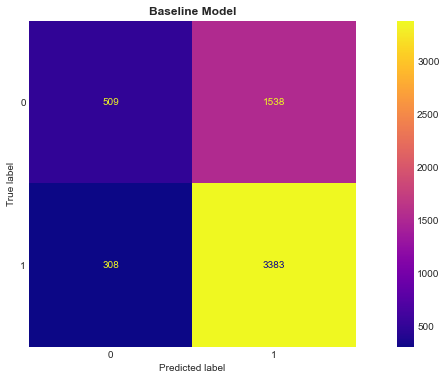

In [42]:
fix, axes = plt.subplots(figsize=(15, 6))

axes.set_title("Baseline Model", weight = 'bold')

plot_confusion_matrix(baseline_model, X_train, y_train,
                      ax=axes, cmap="plasma")

## Cross Validation Checks

### Using `StratifiedKFold`

In [43]:
# Create a Negative log loss using make_scorer from import 
neg_log_loss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Instantiate the model (same as previous example)
baseline_model = LogisticRegression(random_state=42)

# Create a list to hold the score from each fold
kfold_scores = np.ndarray(5)

# Instantiate a splitter object and loop over its result
kfold = StratifiedKFold()
for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    # Extract train and validation subsets using the provided indices
    X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Clone the provided model and fit it on the train subset
    temp_model = clone(baseline_model)
    temp_model.fit(X_t, y_t)
    
    # Evaluate the provided model on the validation subset
    neg_log_loss_score = neg_log_loss(temp_model, X_val, y_val)
    kfold_scores[fold] = neg_log_loss_score
    
-(kfold_scores.mean())

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

0.630863515397326

In [44]:
print(baseline_neg_log_loss_cv)
print(kfold_scores)

[-0.63005753 -0.64001952 -0.63133726 -0.62507209 -0.62783118]
[-0.63005753 -0.64001952 -0.63133726 -0.62507209 -0.62783118]


## Custom Cross Validation Function with `StratifiedKFold`

- note: below if you remove SMOTE, log loss decreases to 0.715, might not need to balance
- standard scaler increases log loss by about 0.08

In [45]:
# Import relevant sklearn and imblearn classes
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def custom_cross_val_score(estimator, X, y):
    # Create a list to hold the scores from each fold
    kfold_train_scores = np.ndarray(5)
    kfold_val_scores = np.ndarray(5)

    # Instantiate a splitter object and loop over its result
    kfold = StratifiedKFold(n_splits=5)
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        # Extract train and validation subsets using the provided indices
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Instantiate StandardScaler
        scaler = StandardScaler()
        # Fit and transform X_t
        X_t_scaled = scaler.fit_transform(X_t)
        # Transform X_val
        X_val_scaled = scaler.transform(X_val)
        
#         # Instantiate SMOTE with random_state=42 and sampling_strategy=0.6
#         sm = SMOTE(random_state = 42, sampling_strategy = 0.60)
#         # Fit and transform X_t_scaled and y_t using sm
#         X_t_oversampled, y_t_oversampled = sm.fit_resample(X_t_scaled, y_t)
        
        # Clone the provided model and fit it on the train subset
        temp_model = clone(estimator)
        temp_model.fit(X_t_scaled, y_t)
        
        # Evaluate the provided model on the train and validation subsets
        neg_log_loss_score_train = neg_log_loss(temp_model, X_t_scaled, y_t)
        neg_log_loss_score_val = neg_log_loss(temp_model, X_val_scaled, y_val)
        kfold_train_scores[fold] = neg_log_loss_score_train
        kfold_val_scores[fold] = neg_log_loss_score_val
        
    return kfold_train_scores, kfold_val_scores
        
model_with_preprocessing = LogisticRegression(random_state=42)
preprocessed_train_scores, preprocessed_neg_log_loss_cv = custom_cross_val_score(model_with_preprocessing, X_train, y_train)
- (preprocessed_neg_log_loss_cv.mean())

0.7146613579551598

In [46]:
# compare to the baseline log loss
print(-baseline_neg_log_loss_cv.mean())
print(-preprocessed_neg_log_loss_cv.mean())

0.630863515397326
0.7146613579551598


In [47]:
# fit the preprocessed model
model_with_preprocessing.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

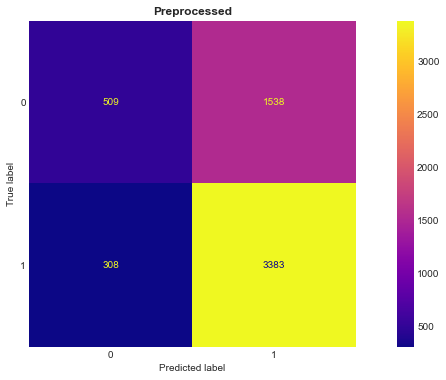

In [48]:
fix, axes = plt.subplots(figsize=(15, 6))

axes.set_title("Preprocessed", weight = 'bold')

plot_confusion_matrix(model_with_preprocessing, X_train, y_train,
                      ax=axes, cmap="plasma")

Might be overfitting a bit, Train scores are slightly better than the validation scores. 

### Reducing Regularization

Check with less regularation. 

In [49]:
model_less_regularization = LogisticRegression(random_state = 42,
                                               C = 1e10)

In [50]:
less_regularization_train_scores, less_regularization_val_scores = custom_cross_val_score(model_less_regularization, X_train, y_train)

print("Previous Model (Standard Scaler)")
print("Train average:     ", -preprocessed_train_scores.mean())
print("Validation average:", -preprocessed_neg_log_loss_cv.mean())
print()
print("Current Model (Reduced Regularization)")
print("Train average:     ", -less_regularization_train_scores.mean())
print("Validation average:", -less_regularization_val_scores.mean())

Previous Model (Standard Scaler)
Train average:      0.5718076025577037
Validation average: 0.7146613579551598

Current Model (Reduced Regularization)
Train average:      0.5717547873081398
Validation average: 0.8674682280037042


Less regularization (ie. higher C value) creates a worse model as the Validation Average increases as C increases. 

In [51]:
# fit the less regularization model
model_less_regularization.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10000000000.0, random_state=42)

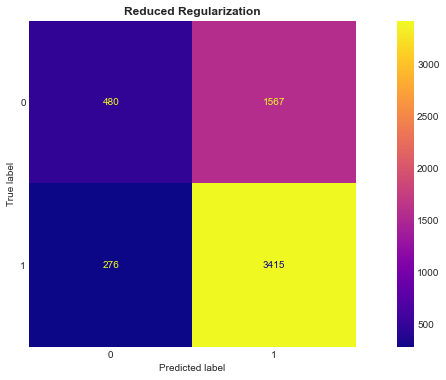

In [52]:
fix, axes = plt.subplots(figsize=(15, 6))

axes.set_title("Reduced Regularization", weight = 'bold')

plot_confusion_matrix(model_less_regularization, X_train, y_train,
                      ax=axes, cmap="plasma")

### Try Different Solvers

In [53]:
print("solver:", model_less_regularization.get_params()["solver"])
print("penalty:", model_less_regularization.get_params()["penalty"])

solver: lbfgs
penalty: l2


In [54]:
# try liblinear as solver
model_liblinear_solver = LogisticRegression(
                            random_state = 42,
                            C = 1,
                            solver = "liblinear",
                            penalty = "l2",
                            max_iter = 1e3, # fixes ConvergenceWarning
                            tol=1) # best scores is when tol = 1

alternative_solver_train_scores, alternative_solver_val_scores = custom_cross_val_score(
    model_liblinear_solver,
    X_train,
    y_train
)

print("Previous Model (Less Regularization)")
print("Train average:     ", -less_regularization_train_scores.mean())
print("Validation average:", -less_regularization_val_scores.mean())
print()
print("Current Model (Liblinear Solver)")
print("Train average:     ", -alternative_solver_train_scores.mean())
print("Validation average:", -alternative_solver_val_scores.mean())

Previous Model (Less Regularization)
Train average:      0.5717547873081398
Validation average: 0.8674682280037042

Current Model (Liblinear Solver)
Train average:      0.5797873301407366
Validation average: 0.6440451581551634


In [55]:
# fit liblinear solver
model_liblinear_solver.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000.0, random_state=42, solver='liblinear',
                   tol=1)

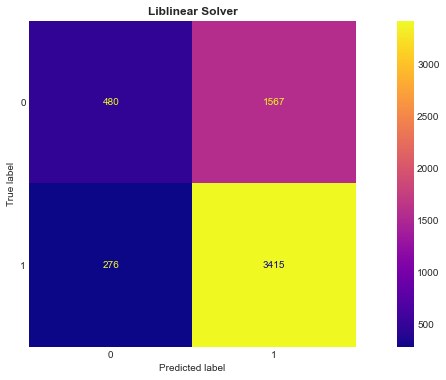

In [56]:
fix, axes = plt.subplots(figsize=(15, 6))

axes.set_title("Liblinear Solver", weight = 'bold')

plot_confusion_matrix(model_less_regularization, X_train, y_train,
                      ax=axes, cmap="plasma")

In [57]:
# try saga as solver
model_saga_solver = LogisticRegression(
                            random_state = 42,
                            C = 1,
                            solver = "saga",
                            penalty = "elasticnet",
                            l1_ratio = 0.9,
                            max_iter = 1e5, # fixes ConvergenceWarning
                            tol=1) # best scores is when tol = 1

alternative_solver_train_scores, alternative_solver_val_scores = custom_cross_val_score(
    model_saga_solver, # change as needed
    X_train,
    y_train
)

print("Current Model (Saga Solver)")
print("Train average:     ", -alternative_solver_train_scores.mean())
print("Validation average:", -alternative_solver_val_scores.mean())

Current Model (Saga Solver)
Train average:      0.6115946242449569
Validation average: 0.6477711371940028


## Use `SelectFromModel`

In [59]:
selector = SelectFromModel(baseline_model)

selector.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SelectFromModel(estimator=LogisticRegression(random_state=42))

In [60]:
thresh = selector.threshold_
thresh

0.17966998719975327

In [61]:
# counts of true and false
sup = selector.get_support()
unique, counts = np.unique(sup, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 253]
 [  1 120]]


In [62]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

In [63]:
X_train_selected = select_important_features(X=X_train, selector=selector)

In [64]:
logreg_sel = LogisticRegression(random_state=2022,C =1)

logreg_sel.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, random_state=2022)

In [65]:
alternative_solver_train_scores, alternative_solver_val_scores = custom_cross_val_score(
    logreg_sel, # change as needed
    X_train,
    y_train
)

print("Current Model (Select From Model)")
print("Train average:     ", -alternative_solver_train_scores.mean())
print("Validation average:", -alternative_solver_val_scores.mean())

Current Model (Select From Model)
Train average:      0.5718076025577037
Validation average: 0.7146613579551598


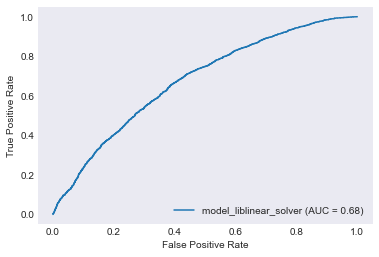

In [66]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_sel, X_train, y_train, 
               name='model_liblinear_solver', ax=ax)

best so far was liblinear model, plot ROC AUC

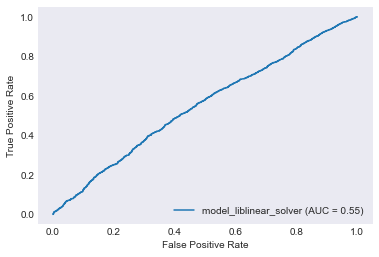

In [67]:
fig, ax = plt.subplots()

plot_roc_curve(model_liblinear_solver, X_train, y_train, 
               name='model_liblinear_solver', ax=ax)

ITS HORRIBLE. CHECK AGAIN

In [ ]:
logreg_model_more_iterations = LogisticRegression(random_state= 42, 
                                  penalty = 'none',
                                  max_iter = 4000)
logreg_model_more_iterations.fit(X_train, y_train)

In [ ]:
logreg_model_higher_tolerance = LogisticRegression(
                                                random_state=2022, 
                                                penalty='none', 
                                                max_iter = 5000,
                                                tol=60
)

logreg_model_higher_tolerance.fit(X_train, y_train)

In [ ]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("Higher Tolerance")

plot_confusion_matrix(logreg_model_more_iterations, X_train, y_train,
                      ax=axes[0], cmap="plasma")
plot_confusion_matrix(logreg_model_higher_tolerance, X_train, y_train,
                      ax=axes[1], cmap="plasma");

In [ ]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [ ]:
logreg_model_more_iterations_results = ModelWithCV(
                                        logreg_model_more_iterations,
                                        'more_iterations',
                                        X_train,
                                        y_train
)
    
logreg_model_higher_tolerance_results = ModelWithCV(
                                        logreg_model_higher_tolerance,
                                        'higher_tolerance',
                                        X_train,
                                        y_train
)

model_results = [
    logreg_model_more_iterations_results,
    logreg_model_higher_tolerance_results
]


In [ ]:
f,axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

for ax, result in zip(axes, model_results):
    ax = result.plot_cv(ax)
    result.print_cv_summary()
plt.tight_layout();

In [ ]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_model_more_iterations, X_train, y_train, 
               name='logreg_model_more_iterations', ax=ax)
plot_roc_curve(logreg_model_higher_tolerance, X_train, y_train, 
               name='logreg_model_higher_tolerance', ax=ax);

## Data Prep - Scaling

In [ ]:
#We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) 

scaler = StandardScaler()

scaler.fit(X_train)

In [ ]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [ ]:
X_train_scaled = scale_values(X_train, scaler)

In [ ]:
X_train_scaled.head()

## 3rd Model - After Scaling

In [ ]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Features Scaled")

plot_confusion_matrix(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");

In [ ]:
X_train.shape

In [ ]:
scaled_features_results = ModelWithCV(
                            logreg_model,
                            'scaled_features',
                            X_train_scaled,
                            y_train
)

In [ ]:
# Saving variable for convenience
model_results = scaled_features_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

In [ ]:
plot_roc_curve(logreg_model, X_train_scaled, y_train)